In [1]:
import numpy as np
import ripser
import persim

from matplotlib import pyplot as plt
from sklearn.decomposition import KernelPCA

In [2]:
def generate_cylinder(n_points, noise=0):
    z = np.random.rand(n_points)
    alphas = np.random.rand(n_points) * 2 * np.pi
    
    x, y = np.cos(alphas), np.sin(alphas)
    
    return np.stack((x, y, z), axis=1) + noise * np.random.randn(n_points, 3)

### For linear PCA we get the following

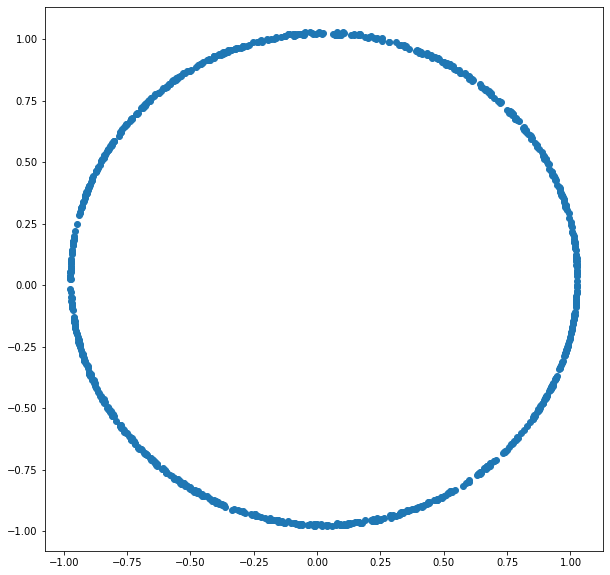

In [3]:
pca = KernelPCA(2)
points = pca.fit_transform(generate_cylinder(1000))

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1])
plt.show()

### For kernel PCA with sigmoid kernel we get this parametric family of images

Gamma = 0.1


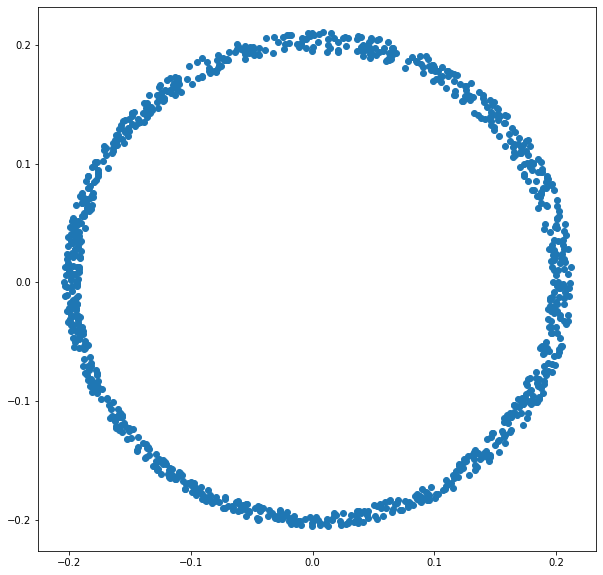

Gamma = 1


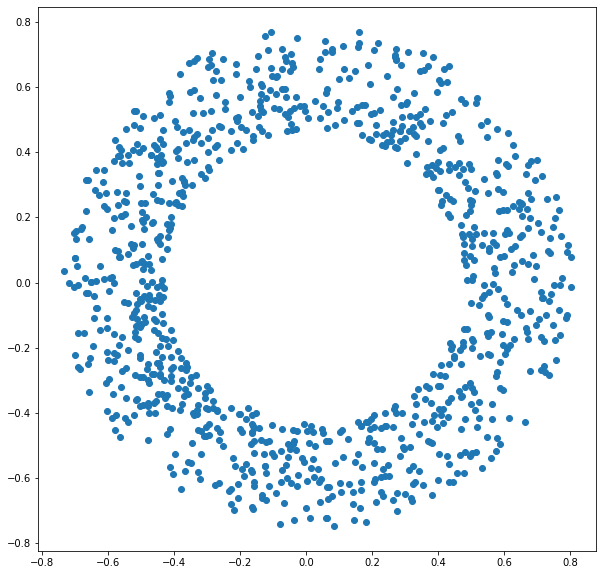

Gamma = 2


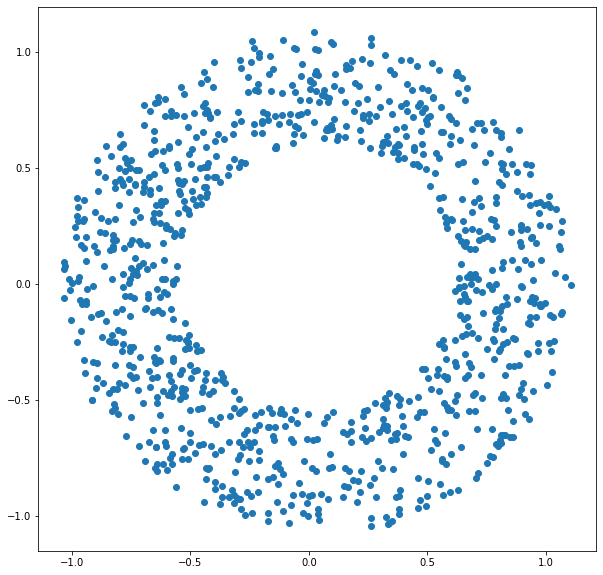

Gamma = 3


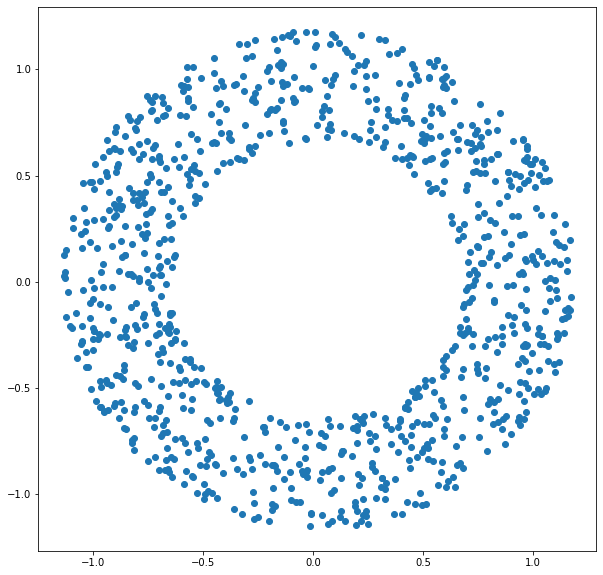

Gamma = 6


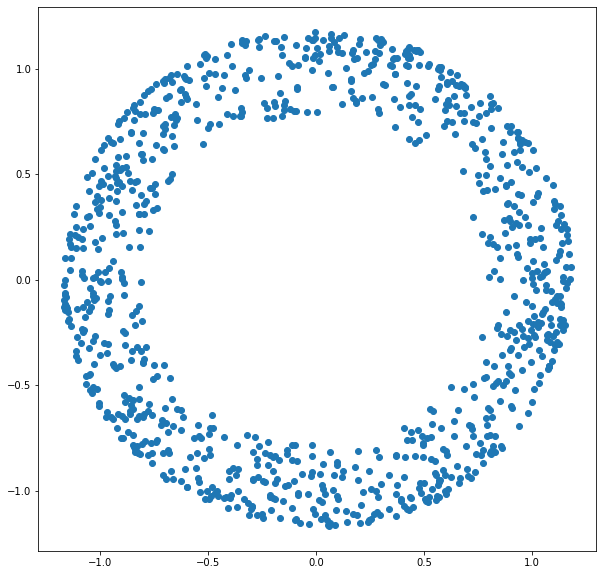

Gamma = 10


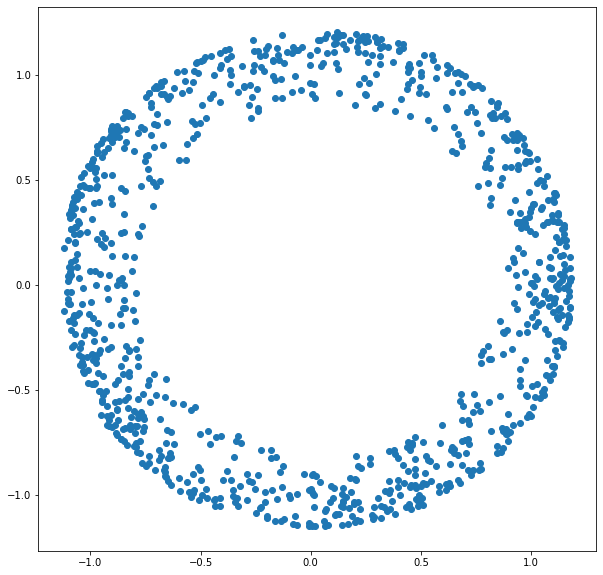

Gamma = 30


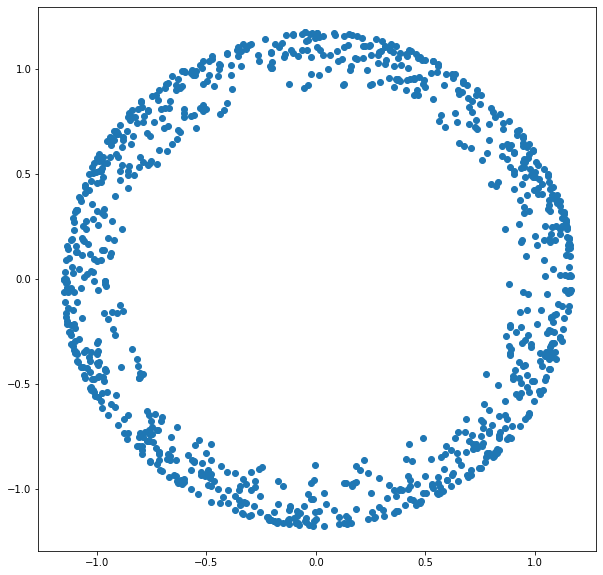

Gamma = 100


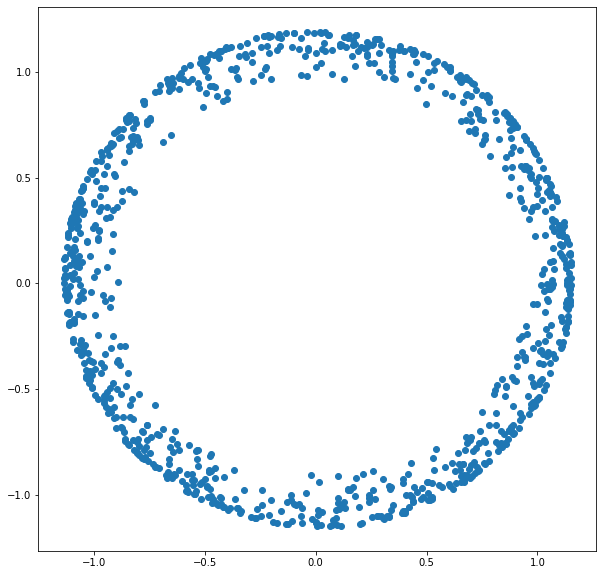

In [4]:
gammas = [0.1, 1, 2, 3, 6, 10, 30, 100]

for gamma in gammas:
    pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

    orig_points = generate_cylinder(1000)
    points = pca.fit_transform(orig_points)

    print('Gamma = {}'.format(gamma))
    
    plt.figure(figsize=(10, 10))

    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

### Now we can calculate the distances

In [5]:
def calc_distance(points_0, points_1):
    pers_0 = ripser.ripser(points_0)
    pers_1 = ripser.ripser(points_1)

    return persim.wasserstein(
        np.concatenate((pers_0['dgms'][0][:-1], pers_0['dgms'][1]), axis=0),
        np.concatenate((pers_1['dgms'][0][:-1], pers_1['dgms'][1]), axis=0)
    )

def calc_distances(gammas, n_points=100):
    results = []
    for gamma in gammas:
        pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)
        
        points_3d = generate_cylinder(n_points)
        points_2d = pca.fit_transform(points_3d)
        
        results.append(calc_distance(points_3d, points_2d))
                       
    return results

In [6]:
distances_list = []
for _ in range(10):
    distances_list.append(calc_distances(gammas, n_points=100))
    
distances = np.array(distances_list)
print(distances)

[[13.62209541  9.52255572  6.52057356  5.47469653  6.66088698  6.07539806
   7.55780478  7.14391423]
 [13.59554309 10.40923256  5.90752263  5.91676058  5.55929058  6.53699439
   6.27617921  7.75880633]
 [13.30209122  9.52915843  8.13925673  5.92810352  6.06378712  5.93035207
   6.07747363  7.06089827]
 [13.52717771 10.07328878  6.95050019  5.74472238  5.91884115  6.78736765
   7.04131584  7.45811325]
 [14.07118868 10.0758949   8.78908031  5.83223207  6.80047605  5.93360498
   6.49127783  6.79436048]
 [14.21139617 10.3858207   6.62274508  6.07752217  6.19074548  6.5023667
   6.54733605  7.1494226 ]
 [14.74567615  9.44313769  6.87987618  4.76826836  6.26195406  6.0435299
   6.54382355  7.6228269 ]
 [13.97743259 10.77158788  6.48294599  6.23679619  6.54205679  6.98530033
   6.98615253  6.9098259 ]
 [13.67181545 10.60895521  6.93156137  6.62386056  6.46374275  7.23104689
   7.34813789  7.38006314]
 [14.38689181  9.73207592  7.45692775  5.24141053  5.90292618  6.38167002
   7.32863193  6.65

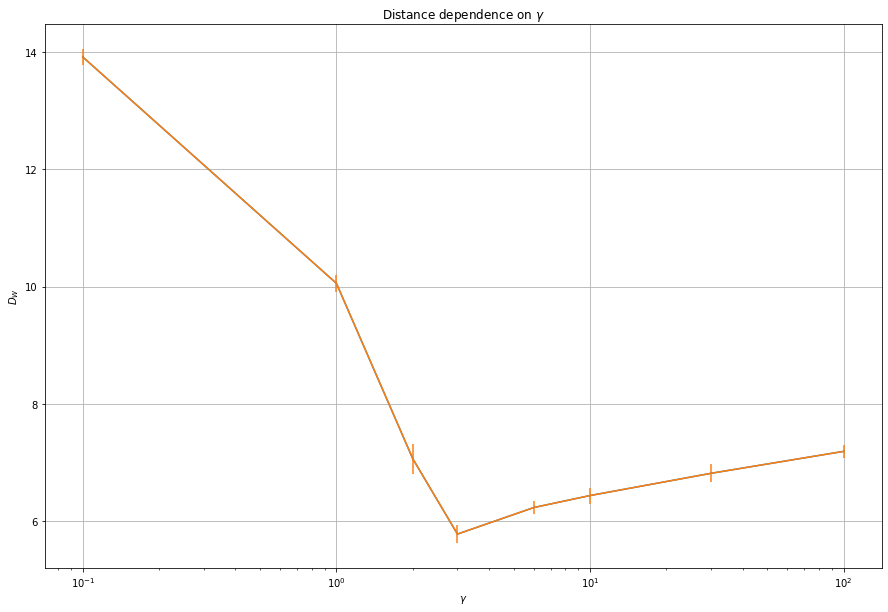

In [7]:
plt.figure(figsize=(15, 10))

plt.semilogx(gammas, distances.mean(axis=0))
plt.errorbar(gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

### We can compare the minimal value with the distance for linear PCA

In [8]:
pca = KernelPCA(2)

distances = []
for _ in range(10):
    points_3d = generate_cylinder(100)
    points_2d = pca.fit_transform(points_3d)
    
    distances.append(calc_distance(points_3d, points_2d))
    
distances = np.array(distances)

print('Linear PCA distance = {} +- {}'.format(distances.mean(), distances.std() / distances.shape[0] ** 0.5))

Linear PCA distance = 10.267393264968895 +- 0.30476421109088797


### Here we will analyse the robustness

In [9]:
new_gammas = np.linspace(2, 6, 20)

print(new_gammas)

distances_list = []
for _ in range(20):
    distances_list.append(calc_distances(new_gammas, n_points=100))
    
distances = np.array(distances_list)

[2.         2.21052632 2.42105263 2.63157895 2.84210526 3.05263158
 3.26315789 3.47368421 3.68421053 3.89473684 4.10526316 4.31578947
 4.52631579 4.73684211 4.94736842 5.15789474 5.36842105 5.57894737
 5.78947368 6.        ]


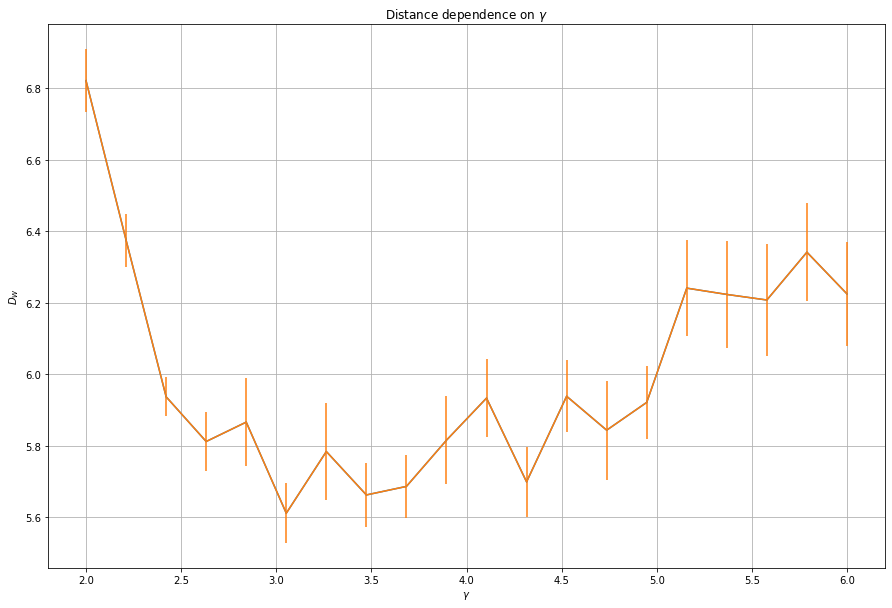

In [10]:
plt.figure(figsize=(15, 10))

plt.plot(new_gammas, distances.mean(axis=0))
plt.errorbar(new_gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

In [11]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

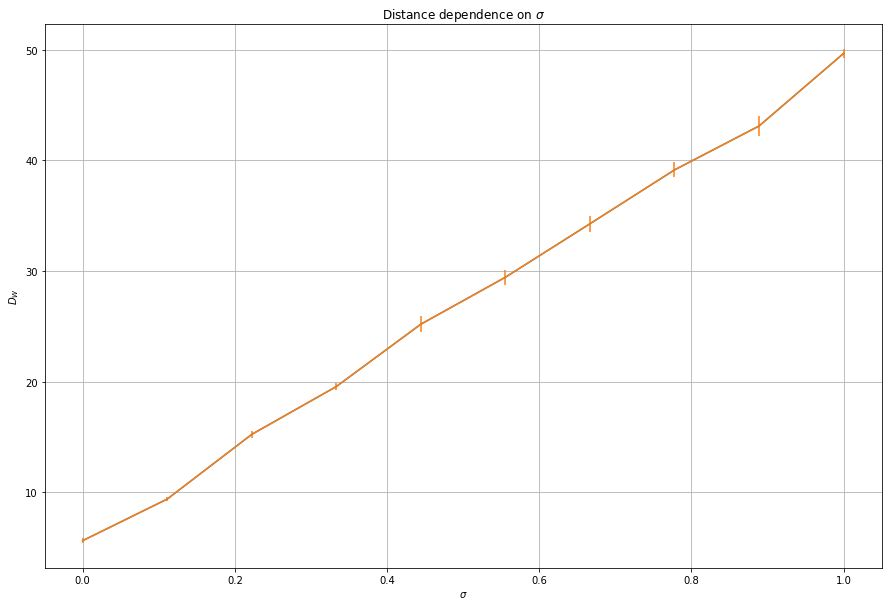

In [12]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

In [13]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 0.1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

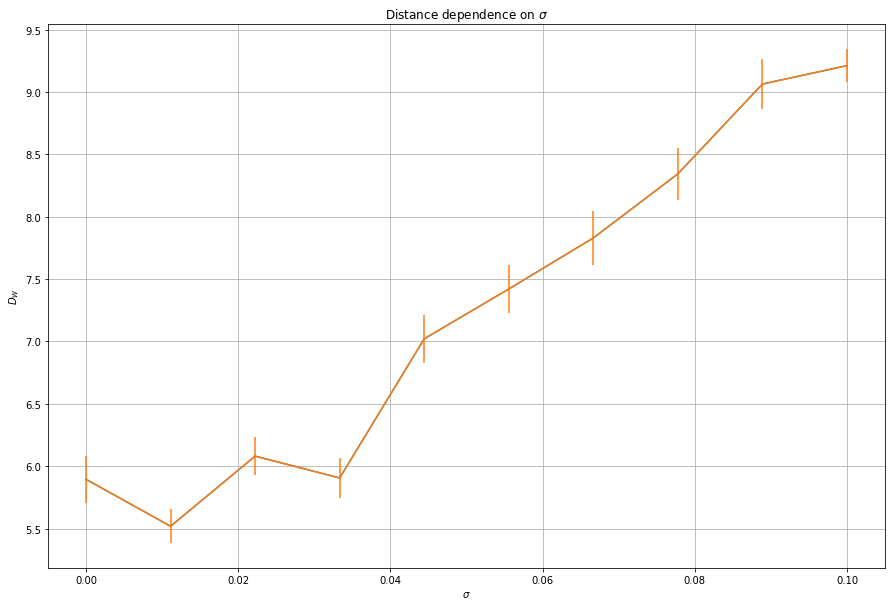

In [14]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 0.1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 0.1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

test
C:\Users\test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=100, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


'\nfor i, (label, method) in enumerate(methods.items()):\n    t0 = time()\n    Y = method.fit_transform(X)\n    t1 = time()\n    print("%s: %.2g sec" % (label, t1 - t0))\n    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))\n    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)\n    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))\n    ax.xaxis.set_major_formatter(NullFormatter())\n    ax.yaxis.set_major_formatter(NullFormatter())\n    ax.axis(\'tight\')\n\nplt.show()\n'

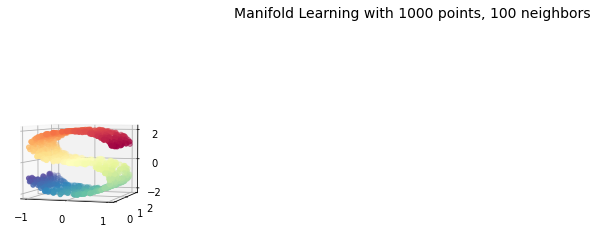

In [15]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 100
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

print("test")

'''
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()
'''

In [16]:
class Centered_Interval:
    def __init__(self, center, interval):
        self.center = center
        self.interval = interval 

    def __str__(self):
        return str([self.center, self.interval])

    def __repr__(self):
        return str(self)

3


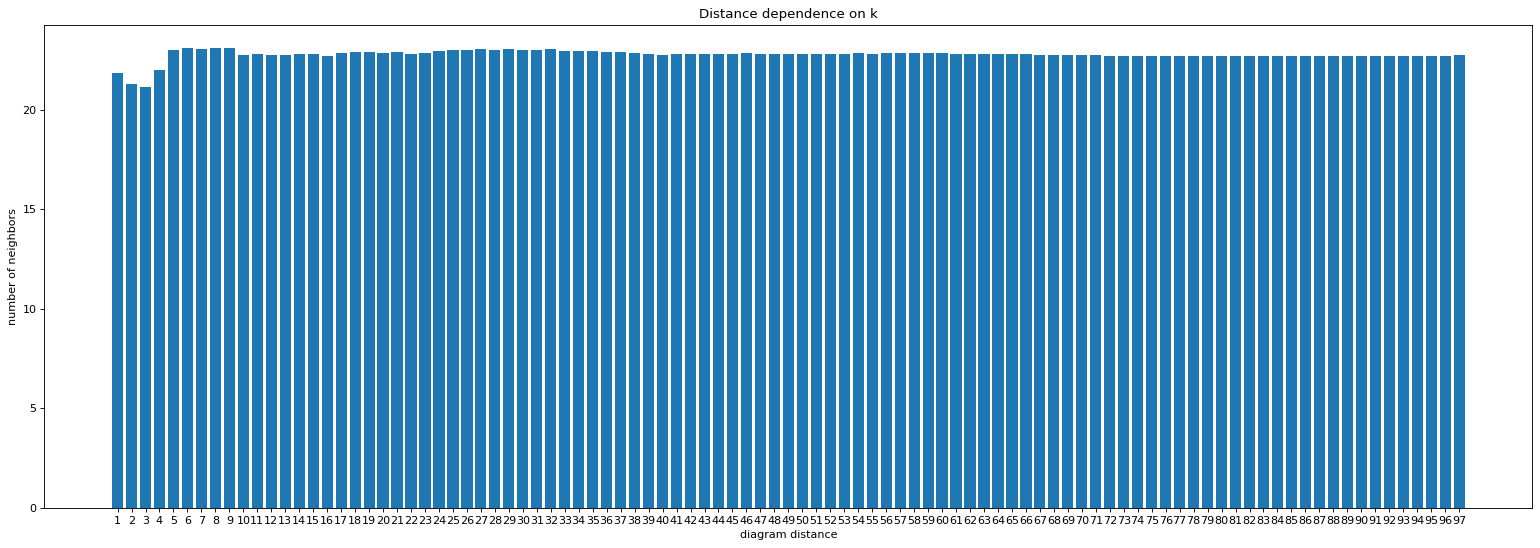

In [34]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets
from matplotlib.pyplot import figure

import math
import time

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

d_distance_between_data_sets = {}                               # key = число ближайших соседей. 
                                                                # Value - диаграммное расстояние между old_data & method.fit_transform(old_data)

def method_initialization(n_components, n_neighbors):
    LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

    methods = OrderedDict()
    methods['LLE'] = LLE(method='standard')
    methods['LTSA'] = LLE(method='ltsa')
    methods['Hessian LLE'] = LLE(method='hessian')
    methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                            n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                    random_state=0)
    return methods 

def dataset_initialization(n_points, dataset):
    if (dataset == 'S_curve'):
        X, color = datasets.make_s_curve(n_points, random_state=0)
        return X, color

def upper_round(number):
    if (number % 1 != 0):
        return int(number + 1 - (number%1))
    return int(number)

def lower_round(number):
    return int(number)

def find_center_points(interval, number_of_intervals, base_ring='Integer'):
    if (base_ring == 'Integer'):
        base_left_cor = interval[0]
        int_length = interval[1] - interval[0]
        interval_length = int_length / number_of_intervals
        centered_intervals_list = []
        max_length = 0
        for pos in range(0, number_of_intervals):
            left_corner = lower_round(interval_length * pos + base_left_cor)
            right_corner = upper_round(interval_length * (pos + 1) + base_left_cor)
            interval = [left_corner, right_corner]
            center = lower_round((left_corner + right_corner) / 2)
            centered_interval = Centered_Interval(center, interval)
            centered_intervals_list.append(centered_interval)
            max_length = max(max_length, right_corner - left_corner)
        return centered_intervals_list, max_length
            
def iterable_object_from_interval(interval, interval_type='k_neighbours'):
    if (interval_type == 'k_neighbours'):
        return range(interval[0], interval[1] + 1)

def find_optimal_subintervals_wrapper(interval, method_name, old_data, 
                                        number_suboptimal_intervals = 3, 
                                        number_of_intervals = 10,
                                        max_length_of_opt_interval = 3,
                                        training_algorithm='k_neighbours'):
    if (training_algorithm == 'k_neighbours'):
        pre_optimal_points = find_optimal_subintervals(interval, method_name, old_data, d_distance_between_data_sets,
                                            number_suboptimal_intervals,
                                            number_of_intervals, max_length_of_opt_interval)
        shortest_distance = math.inf
        closest_neigh = -1 
        if (type(pre_optimal_points) == type([])):
            for pt in pre_optimal_points:
                if pt not in d_distance_between_data_sets:
                    print("ERROR: все точки должны быть инициализированы в словаре соседи-расстояние, но эта точка не заициниализировалась = " + str(pt))
                else:
                    if d_distance_between_data_sets[pt] < shortest_distance:
                        shortest_distance = d_distance_between_data_sets[pt]
                        closest_neigh = pt
        else:
            closest_neigh = pre_optimal_points
        return closest_neigh
            

# Finding sub-optimal parameter for kNN parameter (all methods depends on #k neighbours)
# new_data = method.fit_transform(old_data) - valid for all methods 
# number_of_intervals - число интервалов, на которые делим исходный interval 
# number_suboptimal_intervals - в каждом интервале мы берем середину и смотрим диаграммное расстояние от преобразованных данных до исходных
# этот параметр отвечает за то, сколько параметров рассматриваем в дальнейшем
# Интервал - "непрерывный" сегмент, в котором ищем оптимальное число соседей. Например, interval = [1, 10] - значит будет искать оптимальное число соседей от 1 до 10

# Текущая реализация сильно завязана на то, что ищем оптимальный параметр - число соседей (в частности есть завязка на класс Centered_Interval)
def find_optimal_subintervals(interval, method_name, old_data, d_distance_between_data_sets,
                                number_suboptimal_intervals = 3, 
                                number_of_intervals = 10,
                                max_length_of_opt_interval = 3):
    if (interval[1] == interval[0]):
        if interval[1] not in d_distance_between_data_sets:
            methods = method_initialization(n_components=2, n_neighbors=interval[1])
            method = methods[method_name]
            new_data = method.fit_transform(old_data)
            distance = calc_distance(old_data, new_data)
            d_distance_between_data_sets[interval[1]] = distance 
        return interval[1]

    center_points, max_length = find_center_points(interval, number_of_intervals)         # возвращает середины в разбиении интервала interval на #number_of_intervals 
                                                                                          # а так же максимальную длину интервала                                                 

    if (max_length <= max_length_of_opt_interval):
        distances_list = []                                                               # список списков: distances_list[i] = [kNN, distance_for_k]
                                                                                          # т.е. первое - число соседей для обучения метода, второе - диаграммное расстояние
        for pointed_point in center_points:
            for interval_pt in iterable_object_from_interval(pointed_point.interval):
                if interval_pt not in d_distance_between_data_sets:
                    methods = method_initialization(n_components=2, n_neighbors=interval_pt)
                    method = methods[method_name]
                    new_data = method.fit_transform(old_data)
                    distance = calc_distance(old_data, new_data)
                    d_distance_between_data_sets[interval_pt] = distance 
                distances_list.append([interval_pt, d_distance_between_data_sets[interval_pt]])
        distances_list.sort(key=lambda x: x[1])
        return distances_list[0][0]

    # а вот тут - рекурсия. Выбираем "оптимальные" интервалы (их число - параметр number_suboptimal_intervals)
    # а потом на оптимальных интервалах запускаем снова find_optimal_subintervals
    sub_result = []
    centered_intervals_distance_list = []                                                  # list[i] = [Centered_interval_ins, distance_for_point]
    for pointed_point in center_points:
        center = pointed_point.center
        if center not in d_distance_between_data_sets:
            methods = method_initialization(n_components=2, n_neighbors=center)
            method = methods[method_name]
            new_data = method.fit_transform(old_data)
            distance = calc_distance(old_data, new_data)
            d_distance_between_data_sets[center] = distance 
        centered_intervals_distance_list.append([pointed_point, d_distance_between_data_sets[center]])
    centered_intervals_distance_list.sort(key=lambda x: x[1])
    for i in range(number_suboptimal_intervals):
        sub_result.append(find_optimal_subintervals(interval=centered_intervals_distance_list[i][0].interval,  
                                    method_name=method_name, 
                                    old_data=old_data, 
                                    number_suboptimal_intervals = number_suboptimal_intervals, 
                                    number_of_intervals = number_of_intervals,
                                    max_length_of_opt_interval = max_length_of_opt_interval,
                                    d_distance_between_data_sets = d_distance_between_data_sets))
    return sub_result
        
def speed_test(algorithm_name, n_points, n_neighbors):
    X, color = dataset_initialization(n_points, 'S_curve')
    start = time.time()
    methods = method_initialization(n_components=2, n_neighbors=n_neighbors)
    method = methods[algorithm_name]
    new_data = method.fit_transform(X)
    finish_train = time.time()
    print("обучение для n точек = " + str(n_points) + ", k соседей = " + str(n_neighbors) + ", заняло = " + str(finish_train - start))
    distance = calc_distance(X, new_data)
    finish_calc_dist = time.time()
    print("расчет диаг. расст. для n точек = " + str(n_points) + ", k соседей = " + str(n_neighbors) + ", занял = " + str(finish_calc_dist - finish_train))

def find_optimal_neighbor(algorithm_name, n_points, number_suboptimal_intervals, number_of_intervals):
    X, color = dataset_initialization(n_points, 'S_curve')
    optimal_neighbors = find_optimal_subintervals_wrapper([1, len(X) - 3], algorithm_name, X, 
                                                            number_suboptimal_intervals=number_suboptimal_intervals, 
                                                            number_of_intervals=number_of_intervals)
    return optimal_neighbors

def construct_plot(d_neigh_distance):
    figure(figsize=(24, 8), dpi=80)

    plt.title('Distance dependence on k')
    plt.xlabel('diagram distance')
    plt.ylabel('number of neighbors')


    plt.bar(range(len(d_neigh_distance)), list(d_neigh_distance.values()), align='center')
    plt.xticks(range(len(d_neigh_distance)), list(d_neigh_distance.keys()))
    plt.show()

# speed_test('LTSA', 200, 12)


res = find_optimal_neighbor('LTSA', 100, 50, 50)
print(res)

construct_plot(d_distance_between_data_sets)
